In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from random import random
import time
import scipy
import scipy.sparse.linalg
import utils

## Preparation

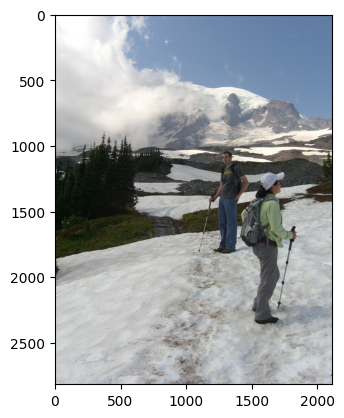

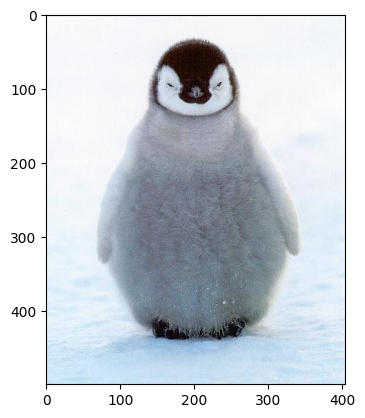

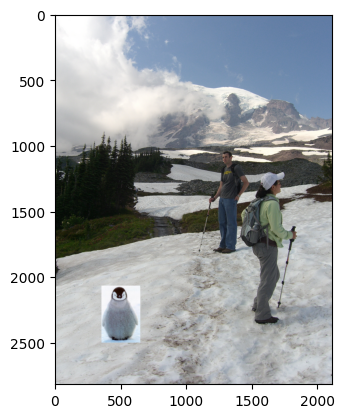

In [3]:
background_img = cv2.cvtColor(cv2.imread('samples/im2.JPG'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure()
plt.imshow(background_img)
plt.show()
object_img = cv2.cvtColor(cv2.imread('samples/penguin-chick.jpeg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.imshow(object_img)
plt.show()

use_interface = False  # set to true if you want to use the interface to choose points (might not work in Colab)
if not use_interface:
	xs = (65, 359, 359, 65)
	ys = (24, 24, 457, 457)
	object_mask = utils.get_mask(ys, xs, object_img)
	bottom_center = (500, 2500) # (x,y)

	object_img, object_mask = utils.crop_object_img(object_img, object_mask)
	bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)
	plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, bg_ul))

In [62]:
img_naive = utils.get_combined_img(background_img, object_img, object_mask, bg_ul)
plt.imsave("naive.jpg", img_naive)

In [4]:
if use_interface:
	import matplotlib.pyplot as plt
	# %matplotlib notebook
	mask_coords = utils.specify_mask(object_img)

In [5]:
if use_interface:
	xs = mask_coords[0]
	ys = mask_coords[1]
	%matplotlib inline
	import matplotlib.pyplot as plt
	plt.figure()
	object_mask = utils.get_mask(ys, xs, object_img)

In [6]:
if use_interface:
	# %matplotlib notebook
	import matplotlib.pyplot as plt
	bottom_center = utils.specify_bottom_center(background_img)
	%matplotlib inline
	import matplotlib.pyplot as plt

	object_img, object_mask = utils.crop_object_img(object_img, object_mask)
	bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)
	plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, bg_ul))

In [56]:
def neighbour(x, y, max_x, max_y):
	pairs = []
	for n in [-1, 1]:
		if 0 <= x+n <= max_x:
			pairs.append((x+n,y))
		if 0 <= y+n <= max_y:
			pairs.append((x,y+n))
	return pairs

In [57]:
def poisson_blend(object_img, object_mask, bg_img, bg_ul):
	"""
	Returns a Poisson blended image with masked object_img over the bg_img at position specified by bg_ul.
	Can be implemented to operate on a single channel or multiple channels
	:param object_img: the image containing the foreground object
	:param object_mask: the mask of the foreground object in object_img
	:param background_img: the background image 
	:param bg_ul: position (row, col) in background image corresponding to (0,0) of object_img 
	"""
	#TO DO
	img_h, img_w = object_img.shape[:2]
	sub_img = bg_img[bg_ul[0]:bg_ul[0]+object_img.shape[0], bg_ul[1]:bg_ul[1]+object_img.shape[1]]
	
	nnz = (object_mask > 0).sum()
	im2var = -np.ones(object_img.shape[:2], dtype="int32")
	im2var[object_mask > 0] = np.arange(nnz)
	
	ys, xs = np.where(object_mask == 1)

	A = scipy.sparse.lil_matrix((4*nnz, nnz))
	b = np.zeros(4*nnz)

	e = 0
	for i in range(nnz):
		y, x = ys[i], xs[i]
		for n_y, n_x in neighbour(y, x, img_h-1, img_w-1):
			A[e, im2var[y][x]] = 1
			b[e] = object_img[y][x] - object_img[n_y][n_x]
			if im2var[n_y][n_x] != -1:
				A[e, im2var[n_y][n_x]] = -1
			else:
				b[e] += sub_img[n_y][n_x]
			e += 1
	
	A = scipy.sparse.csr_matrix(A)
	v = scipy.sparse.linalg.lsqr(A, b)[0]
	
	res = sub_img.copy()

	for n in range(nnz):
		y, x = ys[n], xs[n]
		res[y][x] = v[im2var[y][x]]
	
	res = np.clip(res, 0, 1)

	img_blend = bg_img.copy()
	img_blend[bg_ul[0]:bg_ul[0]+object_img.shape[0], bg_ul[1]:bg_ul[1]+object_img.shape[1]] = res
	return img_blend

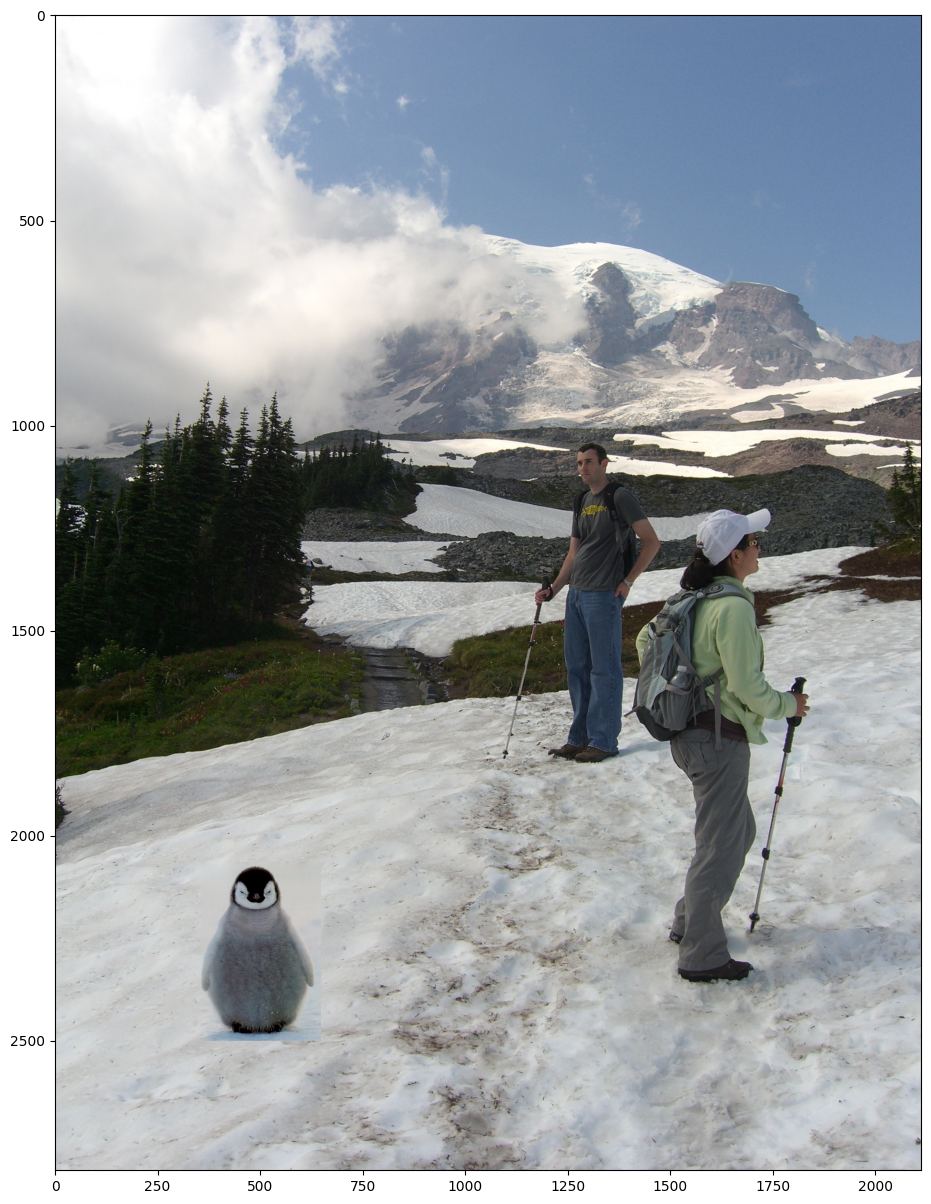

In [58]:
im_blend = np.zeros(background_img.shape)
for b in np.arange(3):
	im_blend[:,:,b] = poisson_blend(object_img[:,:,b], object_mask, background_img[:,:,b].copy(), bg_ul)

plt.figure(figsize=(15,15))
plt.imshow(im_blend)

In [55]:
plt.imsave("poisson.jpg", im_blend)

## Part 3 Mixed Gradients (20 pts)

In [59]:
def mixed_blend(object_img, object_mask, bg_img, bg_ul):
    """
    Returns a mixed gradient blended image with masked object_img over the bg_img at position specified by bg_ul.
    Can be implemented to operate on a single channel or multiple channels
    :param object_img: the image containing the foreground object
    :param object_mask: the mask of the foreground object in object_img
    :param background_img: the background image 
    :param bg_ul: position (row, col) in background image corresponding to (0,0) of object_img 
    """
    #TO DO
    img_h, img_w = object_img.shape
    sub_img = bg_img[bg_ul[0]:bg_ul[0]+object_img.shape[0], bg_ul[1]:bg_ul[1]+object_img.shape[1]]
    
    nnz = (object_mask > 0).sum()
    im2var = -np.ones(object_mask.shape[:2], dtype="int32")
    im2var[object_mask>0] = np.arange(nnz)
    ys, xs = np.where(object_mask==1)
    A = scipy.sparse.lil_matrix((4*nnz, nnz))
    b = np.zeros(4*nnz)
    e = 0
    for n in range(nnz):
        y, x = ys[n], xs[n]
        for ny, nx in neighbour(y, x, img_h-1, img_w-1):
            ds = object_img[y][x] - object_img[ny][nx]
            dt = sub_img[y][x] - sub_img[ny][nx]
            d = ds if abs(ds) > abs(dt) else dt
            A[e, im2var[y][x]] = 1
            b[e] = d
            if im2var[ny][nx] != -1:
                A[e, im2var[ny][nx]] = -1
            else:
                b[e] += sub_img[ny][nx]
            e += 1
    A = scipy.sparse.csr_matrix(A)
    v = scipy.sparse.linalg.lsqr(A, b)[0]
    res = sub_img.copy()
    for n in range(nnz):
        y, x = ys[n], xs[n]
        res[y][x] = v[im2var[y][x]]
    res = np.clip(res, 0, 1)
    img_blend = bg_img.copy()
    img_blend[bg_ul[0]:bg_ul[0]+object_img.shape[0], bg_ul[1]:bg_ul[1]+object_img.shape[1]] = res
    return img_blend

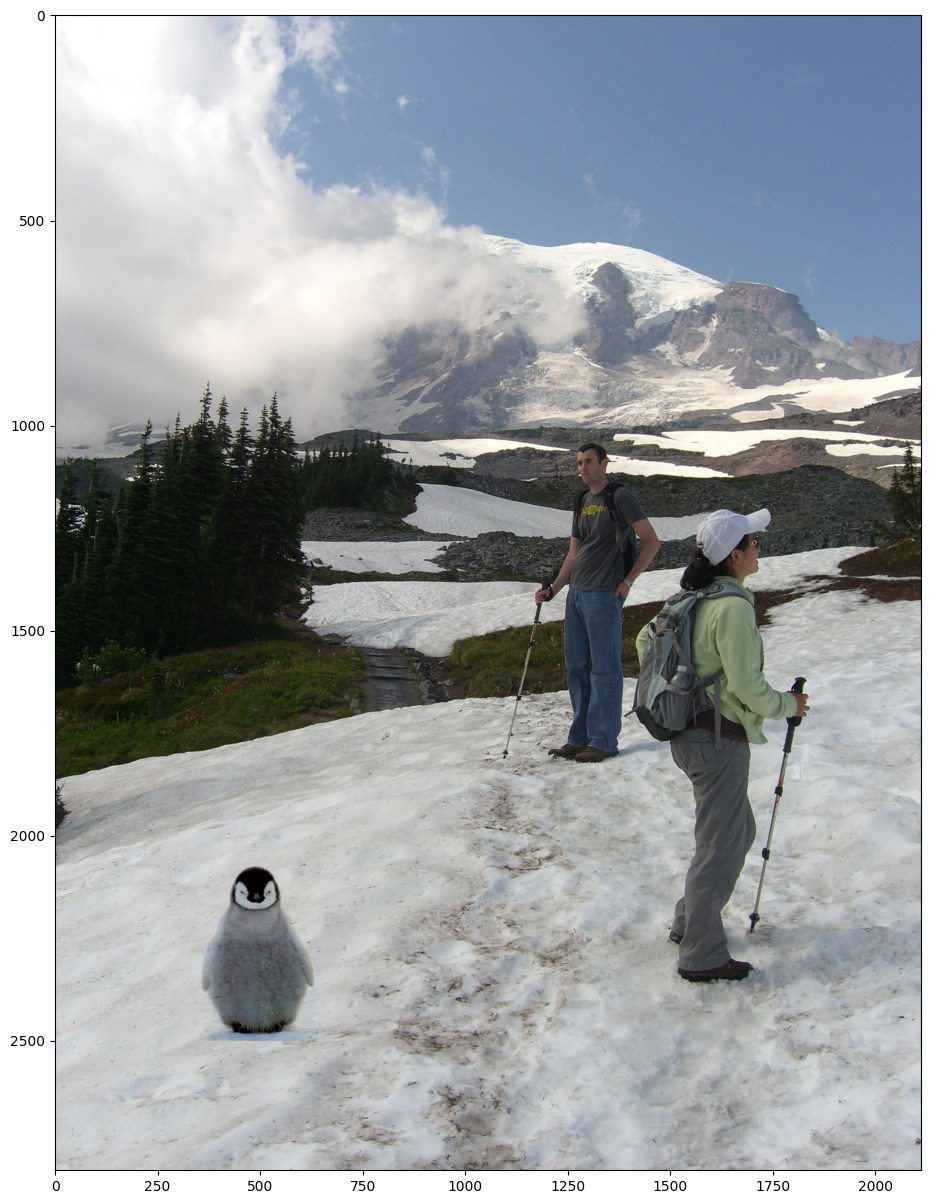

In [60]:
im_mix = np.zeros(background_img.shape)
for b in np.arange(3):
  im_mix[:,:,b] = mixed_blend(object_img[:,:,b], object_mask, background_img[:,:,b].copy(), bg_ul)

plt.figure(figsize=(15,15))
plt.imshow(im_mix)

In [61]:
plt.imsave("mixed.jpg", im_mix)